# Energy macro generation for protons and alpha-particles

In this notebook an improved energy macro generation for protons and alpha-particles is available.

The calculations executed are the same as in the MATLAB scripts, but here the complete macro file is automatically written.

In [17]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [18]:
# Constants for the calculations
meteoriteRadius = 241; # m
phi = 660; # MeV - modulation parameter

Let's define the energy spectra of the two variables, both depending on energy of the particle and modulation parameter.

In [19]:
# Define energy spectrum for protons
def proton_energy_spectrum(E: np.ndarray, phi: float) -> np.ndarray:
    mp = 938.27208816; # MeV - proton rest mass
    A  = 9.9e8;        # m-2 s-1 MeV-1 sr-1

    x  = 780*np.exp(-2.5e-4*E)

    J = A* E*(E + 2*mp)*np.power(E + x + phi, -2.65)
    J = np.divide(J, (E + phi)*(E + 2*mp + phi) ); # particles/(MeV m2 sr s)

    return J


# Define energy spectrum for alphas
def alpha_energy_spectrum(E: np.ndarray, phi: float) -> np.ndarray:
    m = 3727.379378; # MeV - alpha particle mass
    C = 5.5e7;       # particles/(MeV sr s m2)

    k = phi*1.786e-3 - 0.1323

    J = C*np.power(E, k)*(E + 2*m) 
    J = np.divide(J, (E + 700) * (E + 2*m + 700) * np.power(E + 312500*np.power(E, -2.5) + 700, 1.65 + k) )

    return J

Now, let's declare the energy bins for both spectra.

In [20]:
# Protons
energy1 = np.arange(1,    10,     0.05, dtype=float) # MeV
energy2 = np.arange(10,   100,    0.5,  dtype=float) # MeV
energy3 = np.arange(100,  1000,   5,    dtype=float) # MeV
energy4 = np.arange(1000, 5000,   50,   dtype=float) # MeV
energy5 = np.arange(5000, 100500, 500,  dtype=float) # MeV
energyProton  = np.concatenate((energy1, energy2, energy3, energy4, energy5), axis=0) # MeV

# Alphas
energy1 = np.arange(1,    100,    0.5,  dtype=float) # MeV
energy2 = np.arange(100,  1000,   5,    dtype=float) # MeV
energy3 = np.arange(1000, 3000,   50,   dtype=float) # MeV
energy4 = np.arange(3000, 215500, 500,  dtype=float) # MeV
energyAlpha = np.concatenate((energy1, energy2, energy3, energy4), axis=0) # MeV

For simulaiton purposes, it is important to get the total number of particle per second impacting on the asteroid surface for both energy distributions.

In [21]:
# Print the number of particles per second impacting on the asteroid surface

proton_spectrum_integral = quad(proton_energy_spectrum, 0, np.inf, args=(phi,))
NumberOfProtons = proton_spectrum_integral[0]*4*np.pi*np.pi*meteoriteRadius*meteoriteRadius # particles/s
print(f'{NumberOfProtons:.0f} \t protons/s \t on asteroid\'s surface')

alpha_spectrum_integral = quad(alpha_energy_spectrum, 0, np.inf, args=(phi,))
NumberOfAlphas = alpha_spectrum_integral[0]*4*np.pi*np.pi*meteoriteRadius*meteoriteRadius # particles/s
print(f'{NumberOfAlphas:.0f} \t alphas/s \t on asteroid\'s surface')

4445078772 	 protons/s 	 on asteroid's surface
520983707 	 alphas/s 	 on asteroid's surface


Now, everything is ready in orde to determine the energy spectrum histograms.

The histograms are calculated by integral mean over the energy bins.

In [22]:
# Protons
protonMeanFlux = []
for index in range(len(energyProton)-1):
    partialResultProton = quad(proton_energy_spectrum, energyProton[index], energyProton[index+1], args=(phi,))
    partialResultProton = np.divide(partialResultProton, ( energyProton[index+1] - energyProton[index] )) # particles/(MeV m2 sr s)
    protonMeanFlux.append(partialResultProton[0])
protonMeanFlux = np.array(protonMeanFlux)
energyProton = np.delete(energyProton, len(energyProton)-1)

# Alphas
alphaMeanFlux  = []
for index in range(len(energyAlpha)-1):
    partialResultAlpha = quad(alpha_energy_spectrum, energyAlpha[index], energyAlpha[index+1], args=(phi,))
    partialResultAlpha = np.divide(partialResultAlpha, ( energyAlpha[index+1] - energyAlpha[index] )) # particles/(MeV m2 sr s)
    alphaMeanFlux.append(partialResultAlpha[0])
alphaMeanFlux  = np.array(alphaMeanFlux)
energyAlpha  = np.delete(energyAlpha,  len(energyAlpha)-1)

Text(0.5, 1.0, 'Energy spectrum')

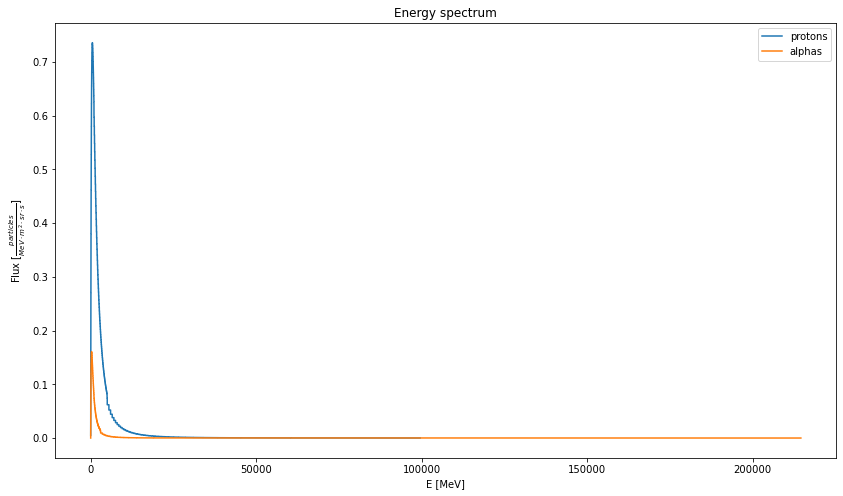

In [23]:
# Plot energy spectrum before saving
plt.figure(figsize=(14,8))
plt.step(energyProton, protonMeanFlux, label='protons')
plt.step(energyAlpha,  alphaMeanFlux,  label='alphas')
plt.xlabel('E [MeV]')
plt.ylabel('Flux [$\\frac{particles}{MeV \\cdot m^2 \\cdot sr \\cdot s}$]')
plt.legend()
plt.title('Energy spectrum')

Finally, write the macros are written with the information extracted.

In [24]:
# Protons
with open('../macro/energyTest_M'+str(phi)+'.mac', 'w') as f:
    
    # Write the initial histrogram info
    f.write('/gps/ene/type Arb\n')
    f.write('/gps/ene/diffspec 1\n')
    f.write('/gps/hist/type arb\n\n\n')

    # Write the energy spectrum
    for index in range(len(energyProton)):
        f.write(f'/gps/hist/point   {energyProton[index]:.2f}   {protonMeanFlux[index]:.9f}\n')
    
    f.write('\n\n/gps/hist/inter Lin\n')

f.close()


# Alphas
with open('../macro/energyTest_M'+str(phi)+'_alpha.mac', 'w') as f:
    
    # Write the initial histrogram info
    f.write('/gps/ene/type Arb\n')
    f.write('/gps/ene/diffspec 1\n')
    f.write('/gps/hist/type arb\n\n\n')

    # Write the energy spectrum
    for index in range(len(energyAlpha)):
        f.write(f'/gps/hist/point   {energyAlpha[index]:.2f}   {alphaMeanFlux[index]:.9f}\n')
    
    f.write('\n\n/gps/hist/inter Lin\n')

f.close()